In [1]:
# 붓꽃 데이터 세트를 DecisionTreeClassifier를 이용하여 학습한뒤
# 규칙트리 형태 확인
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
import graphviz
import warnings
warnings.filterwarnings('ignore')

In [2]:
# DecisionTree Classifier 생성
dt_clf = DecisionTreeClassifier(random_state=156)

# 붗꽃 데이터를 로딩하고, 학습과 테스트 데이터 세트로 분리
iris_data = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris_data.data, iris_data.target,
                                                    test_size=0.2, random_state=11)

# DecisionTreeClassifier 학습
dt_clf.fit(X_train, y_train)

# (학습이 완료된 estimator, output 파일명, 결정 클래스 명칭, 피처의 명칭)
# 호출 결과로 out_file로 지정된 tree.dot 파일 생성
export_graphviz(dt_clf, out_file='tree.dot', class_names = iris_data.target_names,
                feature_names = iris_data.feature_names, impurity=True, filled=True)

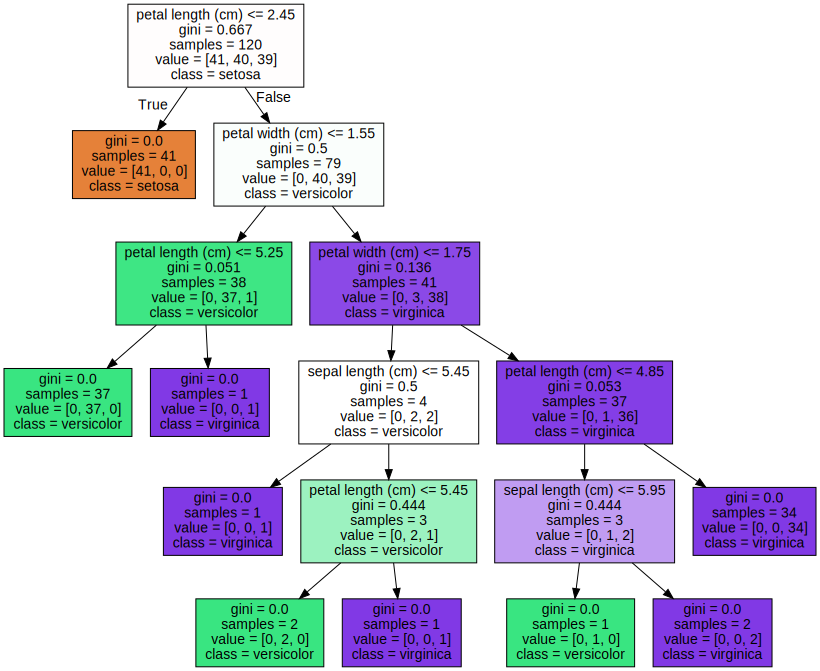

In [3]:
# 위에서 생성된 출력파일 tree.dot 파일을 Graphviz가 읽어서 시각화
with open('tree.dot') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

Feature importances:
[0.025 0.    0.555 0.42 ]
sepal length (cm) : 0.025
sepal width (cm) : 0.000
petal length (cm) : 0.555
petal width (cm) : 0.420


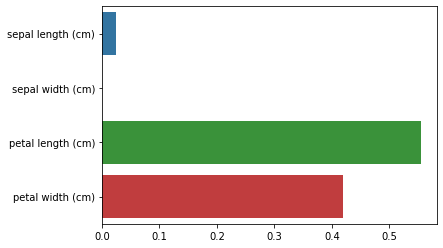

In [4]:
import seaborn as sns
import numpy as np
%matplotlib inline

# feature importance 추출
print("Feature importances:\n{0}".format(np.round(dt_clf.feature_importances_, 3)))

# feature 별 importance 매핑
for name, value in zip(iris_data.feature_names, dt_clf.feature_importances_):
    print('{0} : {1:.3f}'.format(name, value))

# feature importance를 column 별로 시각화
sns.barplot(x=dt_clf.feature_importances_, y = iris_data.feature_names)

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# feautres.txt 파일에는 피처 이름 index와 피처명이 공백으로 분리되어 있음
feature_name_df = pd.read_csv('/content/drive/MyDrive/machine_learning_data/human_activity/features.txt',
                              sep='\s+', header=None, names=['column_index','column_name'])


# 피처명 index를 제거하고, 피처명만 리스트 객체로 생성
feature_name = feature_name_df.iloc[:,1].values.tolist()
print('전체 피처명에서 10개만 추출:', feature_name[:10])

전체 피처명에서 10개만 추출: ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


In [6]:
# 피처명에 중복값이 있으면 DataFrame 생성에서 오류 발생

# 피처명으로 묶고, 이에 대한 개수 확인
feature_dup_df = feature_name_df.groupby('column_name').count()

# 이 중, 개수가 1 초과인 피처들 계산
print(feature_dup_df[feature_dup_df['column_index']>1].count())
feature_dup_df[feature_dup_df['column_index']>1].head()

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


In [7]:
# 중복된 피처명에 대해, 원본 피처명에 _1 또는 _2를 추가로 부여하여
# 새로운 피처명을 가지는 DataFrame을 반환하는 함수 생성
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name','dup_cnt']].apply(lambda x:x[0] +'_'+str(x[1]) if x[1]>0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [8]:
def get_human_dataset():

    #각 데이터 파일은 공백으로 구분되어 있으므로 read_csv에서 공백 문자를 sep으로 할당함
    feature_name_df = pd.read_csv('/content/drive/MyDrive/machine_learning_data/human_activity/features.txt',
                                  sep='\s+', header=None, names=['column_index','column_name'])
    
    #중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame 생성
    new_feature_name_df = get_new_feature_name_df(feature_name_df)

    #DataFrame에 피처명을 칼럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:,1].values.tolist()

    # 학습 피처 데이터세트와 피처 데이터를 DataFrame으로 로딩
    X_train = pd.read_csv('/content/drive/MyDrive/machine_learning_data/human_activity/train/X_train.txt',
                          sep='\s+',names=feature_name)
    X_test = pd.read_csv('/content/drive/MyDrive/machine_learning_data/human_activity/test/X_test.txt',
                         sep='\s+',names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터를 DataFrame으로 로딩
    y_train = pd.read_csv('/content/drive/MyDrive/machine_learning_data/human_activity/train/y_train.txt',
                          sep='\s+', names = ['action'])
    y_test = pd.read_csv('/content/drive/MyDrive/machine_learning_data/human_activity/test/y_test.txt',
                         sep='\s+', names=['action'])
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

# 7352개의 레코드와 561개의 피처, 피처는 모두 float이므로 인코딩 필요 없음
print(X_train.info())

# 레이블 값은 1,2,3,4,5,6의 6개 값이며, 분포도는 왜곡되지 않고 고르게 분포
print(y_train['action'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None
6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64


In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# DecisionTreeClassfier의 인자를 통해
# 직접적으로 하이퍼 파라미터 튜닝 가능
dt_clf = DecisionTreeClassifier(random_state=156, min_samples_leaf=7, max_depth=8)
dt_clf.fit(X_train, y_train)
pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('결정 트리 예측 정확도: {0:.4f}'.format(accuracy))

# DecisionTreeClassifier의 하이퍼 파라미터 추출
print('DecisionTreeClassifier 기본 하이퍼 파라미터:\n', dt_clf.get_params())

결정 트리 예측 정확도: 0.8795
DecisionTreeClassifier 기본 하이퍼 파라미터:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 8, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 7, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 156, 'splitter': 'best'}


In [42]:
from sklearn.model_selection import GridSearchCV

# GridSerachCV를 통해 교차 검증 + 하이퍼 파라미터 튜닝
params = {
    'max_depth' : [6,7,8,9,10,11,12]
}

# GridSearchCV의 iteration시마다 수행 결과 메시지를 출력합니다.
# verbose=0(default)면 메시지 출력 안함
# verbose=1이면 간단한 메시지 출력
# verbose=2이면 하이퍼 파라미터별 메시지 출력

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring = 'accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터: ',grid_cv.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
GridSearchCV 최고 평균 정확도 수치: 0.8538
GridSearchCV 최적 하이퍼 파라미터:  {'max_depth': 9}


In [44]:
# 하이퍼 파리미터를 순차적으로 입력했을 때의 성능 수치를 평가
# GridSearchCV 객체의 cv_results_ 속성을 DataFrame으로 생성
cv_results_df = pd.DataFrame(grid_cv.cv_results_)

# max_depth 파라미터 값과 그 때의 테스트 세트, 학습 데이터 세트의 정확도 수치 추출
# mean_test_score: 5개의 cv 세트에서 검증용 데이터 세트의 정확도 평균 수치
cv_results_df[['param_max_depth','mean_test_score']]

,param_max_depth,mean_test_score
0,6,0.848478
1,7,0.851614
2,8,0.850796
3,9,0.853790
4,10,0.852701
5,11,0.851339
6,12,0.847396


In [45]:
# max_depth 값을 변화시키면서 학습과 테스트 세트에서의 예측 성능 측정
max_depth = [6,8,10,12,16]
for depth in max_depth:
    dt_clf = DecisionTreeClassifier(max_depth = depth, random_state=156)
    dt_clf.fit(X_train, y_train)
    pred = dt_clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    print('max_depth = {0} 정확도: {1:.4f}'.format(depth, accuracy))

max_depth = 6 정확도: 0.8558
max_depth = 8 정확도: 0.8707
max_depth = 10 정확도: 0.8673
max_depth = 12 정확도: 0.8646
max_depth = 16 정확도: 0.8575


In [49]:
# max_depth와 min_samples_split을 같이 변경하며 정확도 성능 튜닝
params={
    'max_depth':[5,6,7,8],
    'min_samples_split':[16,24]
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
GridSearchCV 최고 평균 정확도 수치: 0.8549
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 8, 'min_samples_split': 16}


In [50]:
# 하이퍼 파리미터를 순차적으로 입력했을 때의 성능 수치를 평가
# GridSearchCV 객체의 cv_results_ 속성을 DataFrame으로 생성
cv_results_df = pd.DataFrame(grid_cv.cv_results_)

# max_depth 파라미터 값과 그 때의 테스트 세트, 학습 데이터 세트의 정확도 수치 추출
# mean_test_score: 5개의 cv 세트에서 검증용 데이터 세트의 정확도 평균 수치
cv_results_df[['param_max_depth','param_min_samples_split','mean_test_score']]

,param_max_depth,param_min_samples_split,mean_test_score
0,5,16,0.847936
1,5,24,0.850113
2,6,16,0.847662
3,6,24,0.846575
4,7,16,0.849980
5,7,24,0.850933
6,8,16,0.854879
7,8,24,0.851342


In [51]:
best_df_clf = grid_cv.best_estimator_
pred1 = best_df_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred1)
print('결정 트리 예측 정확도: {0:.4f}'.format(accuracy))

결정 트리 예측 정확도: 0.8717


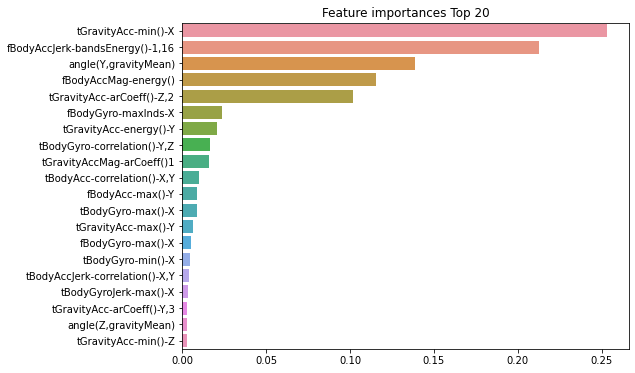

In [54]:
# 각 피처의 중요도
import seaborn as sns

# 결정트리에서 각 피처의 중요도를 나타내는 속성
ftr_importances_values = best_df_clf.feature_importances_

# Top 중요도로 정렬을 쉽게하고, 시본의 막대그래프로 쉽게 표현하기 위해 Series 변환
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)

# 중요도값 순으로 정렬
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y= ftr_top20.index)
plt.show()